In [111]:
import pickle
import warnings
import maya

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from datetime import datetime as dt, date
from scipy import stats
from sklearn import decomposition, manifold
from annoy import AnnoyIndex
from itertools import product

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [221]:
embeds, rows = [], []

for path in tqdm(glob('../data/embeds-en/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            embeds.append(line.pop('embedding'))
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 65/65 [00:28<00:00,  2.30it/s]


In [222]:
embeds = np.stack(embeds)

In [223]:
df = pd.DataFrame(rows)

In [224]:
domains = list(df.label.unique())

In [225]:
domains

['apnews.com',
 'washingtonpost.com',
 'breitbart.com',
 'dailykos.com',
 'nytimes.com',
 'foxnews.com',
 'bloomberg.com',
 'cnn.com',
 'huffingtonpost.com',
 'wsj.com',
 'buzzfeed.com',
 'dailycaller.com',
 'thehill.com']

In [226]:
embeds.shape

(642237, 512)

In [227]:
df = df[df.first_ts > dt(2017, 1, 1).timestamp()]

In [228]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.label}'], axis=1)

In [229]:
embeds = embeds[df.index]

In [230]:
embeds.shape

(626690, 512)

In [236]:
df = df.reset_index()

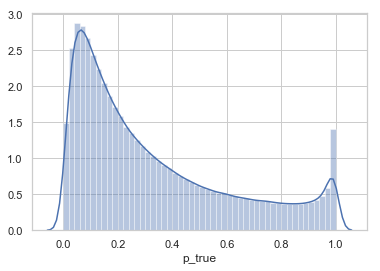

In [238]:
sns.distplot(df.p_true)

In [242]:
df['date'] = df.first_ts.apply(lambda ts: dt.fromtimestamp(ts).date())

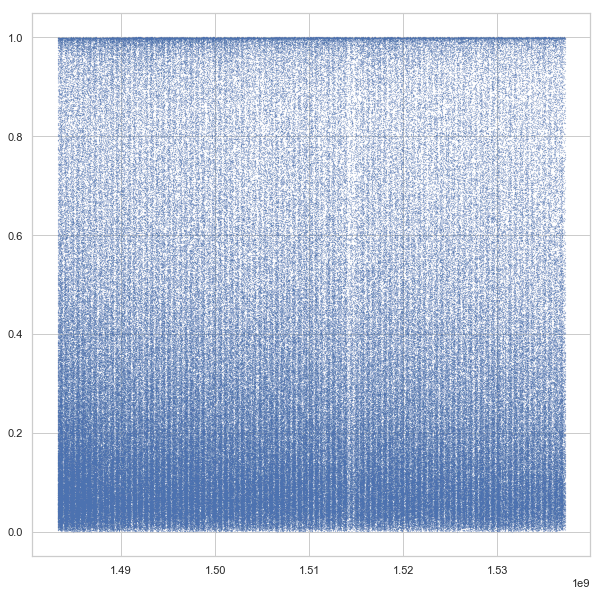

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(df.first_ts, df.p_true, s=0.01)

In [22]:
mean_pt = df.groupby('date').mean()['p_true']

In [23]:
mean_pt.sort_index(inplace=True)

# Overall p-true

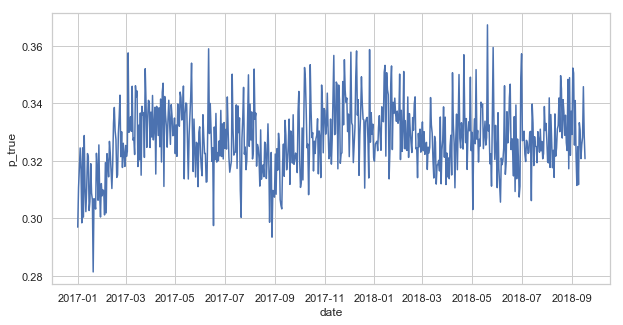

In [28]:
plt.figure(figsize=(10,5))
sns.lineplot(mean_pt.index, mean_pt, err_style='band')

In [131]:
def plot_pair(d1, d2, w=8, h=3):
    dfp = df[df.label==d1]
    plt.figure(figsize=(w,h))
    sns.lineplot(dfp.date, dfp[f'p_{d2}'])
    plt.show()

# Per-outlet p-true

apnews.com


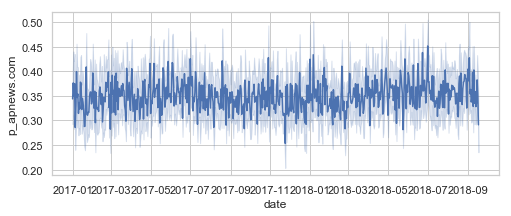

washingtonpost.com


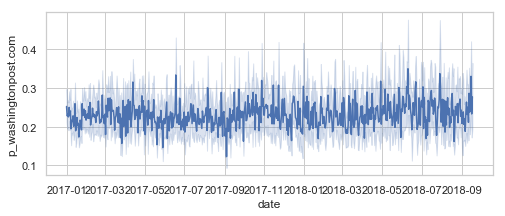

breitbart.com


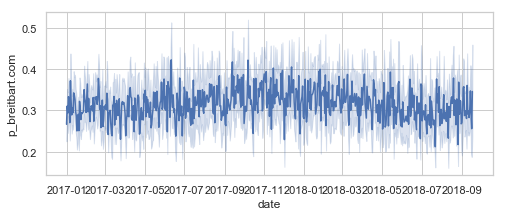

dailykos.com


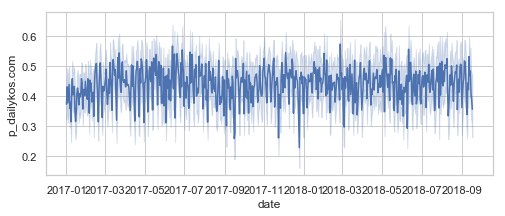

nytimes.com


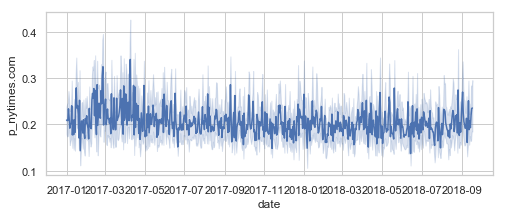

foxnews.com


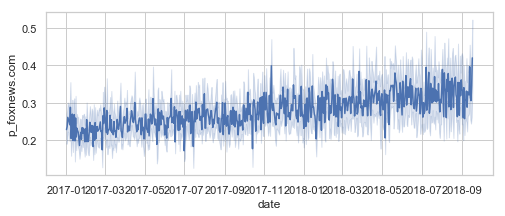

bloomberg.com


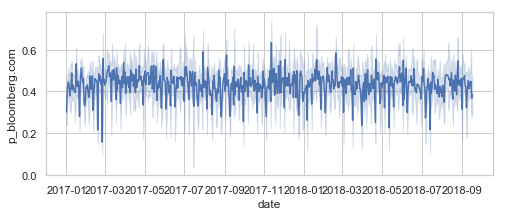

cnn.com


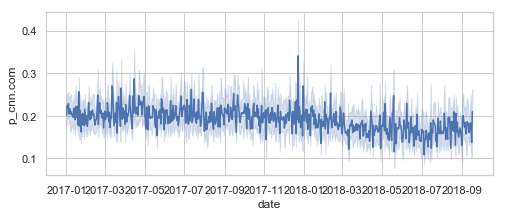

huffingtonpost.com


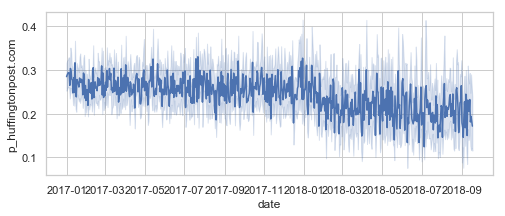

wsj.com


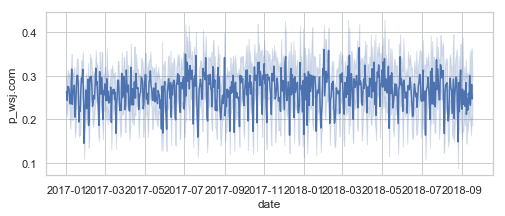

buzzfeed.com


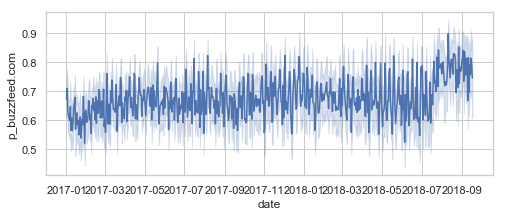

dailycaller.com


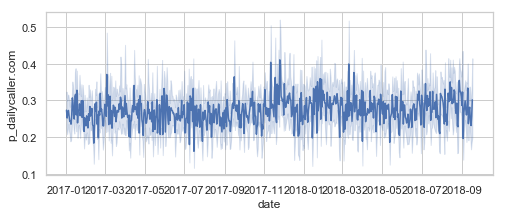

thehill.com


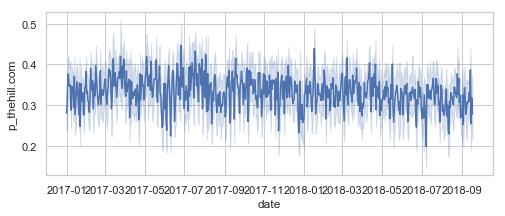

In [132]:
for d in df.label.unique():
    print(d)
    plot_pair(d, d)

In [113]:
rows = []
for d1, d2 in tqdm(product(domains, domains)):
    dfp = df[df.label==d1]
    lr = stats.linregress(dfp.first_ts, dfp[f'p_{d2}'])
    rows.append((d1, d2, lr.slope, lr.pvalue))

169it [00:23,  7.28it/s]


In [116]:
lrdf = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'p'))

foxnews.com foxnews.com


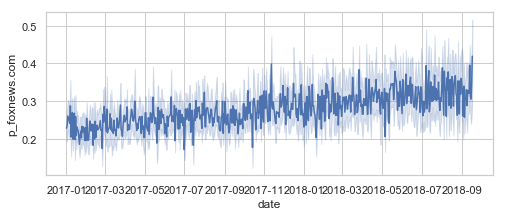

buzzfeed.com buzzfeed.com


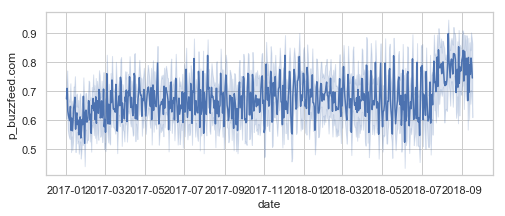

nytimes.com apnews.com


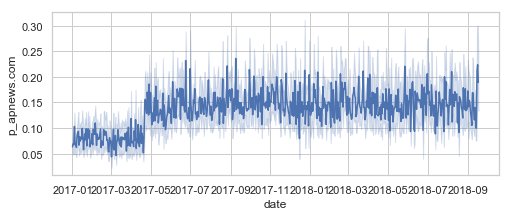

huffingtonpost.com foxnews.com


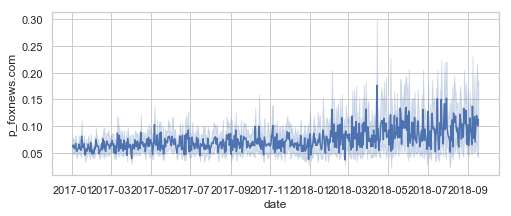

dailycaller.com dailycaller.com


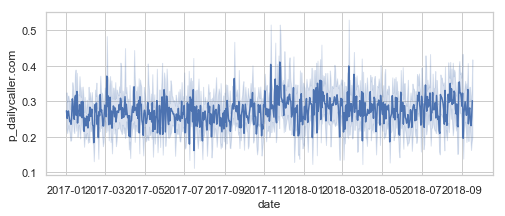

huffingtonpost.com dailycaller.com


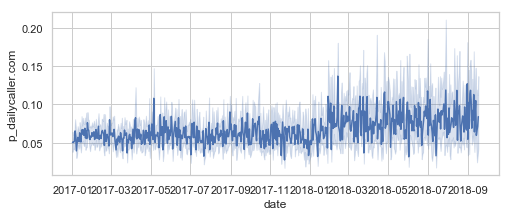

cnn.com washingtonpost.com


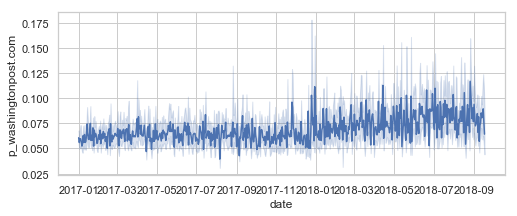

nytimes.com bloomberg.com


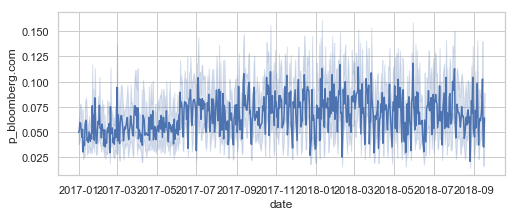

nytimes.com foxnews.com


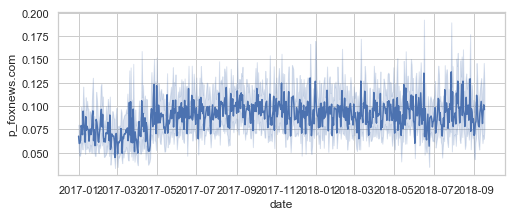

cnn.com dailykos.com


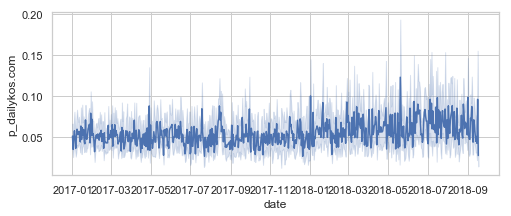

In [141]:
for r in lrdf.sort_values('slope', ascending=False).head(10).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)

huffingtonpost.com huffingtonpost.com


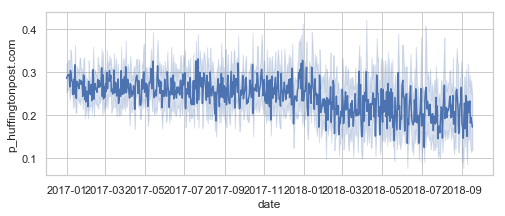

cnn.com cnn.com


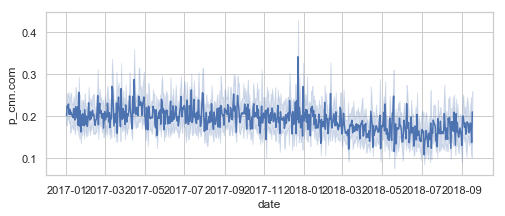

thehill.com thehill.com


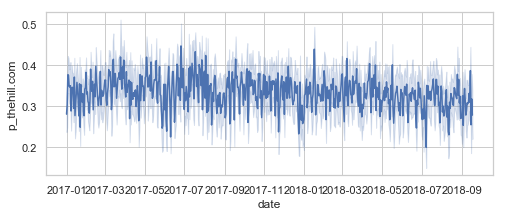

thehill.com cnn.com


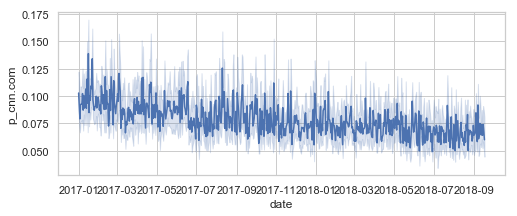

buzzfeed.com huffingtonpost.com


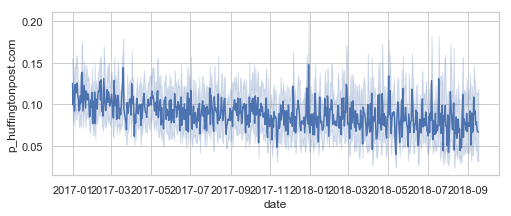

nytimes.com huffingtonpost.com


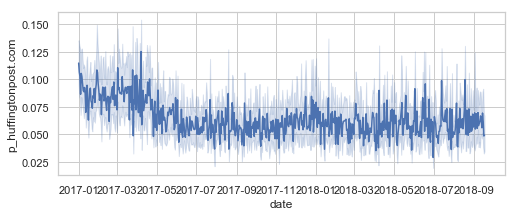

dailycaller.com thehill.com


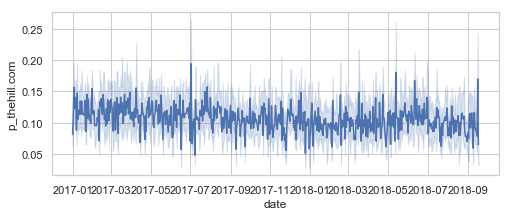

nytimes.com nytimes.com


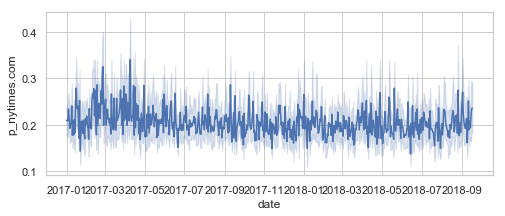

foxnews.com apnews.com


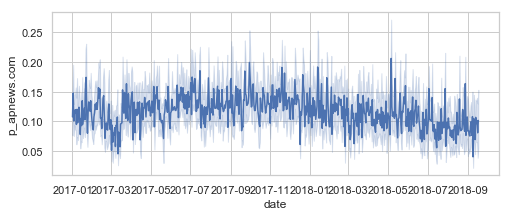

foxnews.com thehill.com


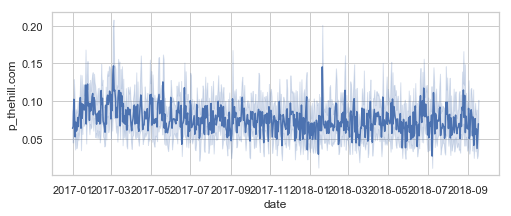

In [142]:
for r in lrdf.sort_values('slope', ascending=True).head(10).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)

In [239]:
idx = AnnoyIndex(embeds.shape[1])

for i, v in tqdm(enumerate(embeds)):
    idx.add_item(i, v)
    
idx.build(10)

626690it [00:48, 12984.05it/s]


True

In [257]:
def print_shift(d):

    t1_all = embeds[df[(df.date < date(2017, 2, 1))&(df.label==d)].index]
    t2_all = embeds[df[(df.date > date(2018, 7, 1))&(df.label==d)].index]

    for i in idx.get_nns_by_vector(t2_all.mean(0) - t1_all.mean(0), 50):
        row = df.iloc[i]
#         if row.label == d:
        print(row.label, row.title)

In [260]:
print_shift('foxnews.com')

huffingtonpost.com terrifying body cam footage shows deputy driving through raging california wildfire
foxnews.com britney spears ex husband kevin federline reportedly rejects child support proposal
foxnews.com bellhop reportedly helped las vegas gunman with bags as resort cops differ over timeline
foxnews.com below deck star captain lee rosbach recalls outrageous requests from rich guests
foxnews.com rachael ray s dog food brand nutrish sued for allegedly containing potentially harmful herbicide
foxnews.com shocking new details of matt lauer s alleged affair with much younger assistant revealed
foxnews.com massage envy employees accused of sexual assault by over # women bombshell report claims
foxnews.com storms reportedly force united airlines to fly # from san francisco to los angeles
foxnews.com xxxtentacion s mom reveals rapper s mausoleum calls him her guardian angel in instagram post
foxnews.com largest bass caught in texas lake using mcdonald s chicken mcnugget
foxnews.com hawa